# MINIST
获取MNIST数据

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="./datasets")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

#### 获取不到MNIST数据，另外使用 "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 获取的数据。

In [9]:
def fetch_mldata_alternative():
    from six.moves import urllib
    from sklearn.datasets import fetch_mldata
    try:
        # mnist = fetch_mldata('MNIST original')
        mnist = fetch_mldata('MNIST original', data_home='./datasets')
    except:
        print("Could not download MNIST data from mldata.org, trying alternative...")

        # Alternative method to load MNIST, if mldata.org is down
        from scipy.io import loadmat
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        mnist_path = "./mnist-original.mat"
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        mnist = {
            "data": mnist_raw["data"].T,
            "target": mnist_raw["label"][0],
            "COL_NAMES": ["label", "data"],
            "DESCR": "mldata.org dataset: mnist-original",
        }
        print("Success!")
    return mnist

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

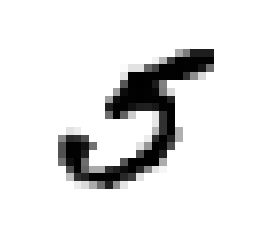

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()